In [1]:
# Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import itertools as itt
import pickle as pk

full_train = pd.read_parquet('../data/cleaned/all_features_train.parquet')
full_test = pd.read_parquet('../data/cleaned/all_features_test.parquet')

In [2]:
# Split test and train data sets into X, y_norm, and y_log
X_train, y_train_norm, y_train_log = (full_train.drop(['price', 'log(price_plus_0)'], axis = 1),
                                      full_train.price,
                                      full_train['log(price_plus_0)'])
X_test, y_test_norm, y_test_log = (full_test.drop(['price', 'log(price_plus_0)'], axis = 1),
                                      full_test.price,
                                      full_test['log(price_plus_0)'])

In [3]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'view', 'condition',
       ...
       'grade_Very_Good_x_zipcode_98168', 'grade_Very_Good_x_zipcode_98177',
       'grade_Very_Good_x_zipcode_98178', 'grade_Very_Good_x_zipcode_98188',
       'grade_Very_Good_x_zipcode_98198', 'grade_Very_Good_x_zipcode_98199',
       'grade_Very_Good_x_zipcode_98224', 'grade_Very_Good_x_zipcode_98251',
       'grade_Very_Good_x_zipcode_98288', 'grade_Very_Good_x_zipcode_98354'],
      dtype='object', length=3264)

In [4]:
# Add columns of zeroes for each column present in X_train but not present in X_test
# zipcode_98050 was not present in X_test and was duplicated through one-hot-encoding and engineered interactions
# Since all of these columns represent dummy variables, this should not affect modeling whatsoever
# X_test and X_train need to have the same shape for sklearn LinearRegression()
def equalize_columns(df_1, df_2):
    col_to_add_1 = [x for x in df_2.columns if x not in df_1.columns]
    col_to_add_2 = [x for x in df_1.columns if x not in df_2.columns]
    
    if col_to_add_1 != []:
        for col in col_to_add_1:
            df_1[col] = 0
            
    if col_to_add_2 != []:
        for col in col_to_add_2:
            df_2[col] = 0
            
    df_1_col_order = df_1.columns.values.tolist()
    
    df_2.reindex(columns = df_1_col_order)
    

equalize_columns(X_train, X_test)

In [5]:
# Runs a linear regression fitted on train data, then predicts on test data using a specified column set
# Creates a pandas DataFrame containing the R^2 value of X_train, y_train
# as well as the R^2 value obtained from predicting on X_test using coefficients from fitting on X_train
# Also contains the fitted coefficient names/values/p-scores
# Returns the y_prediction from predicting on X_test and the pandas DataFrame with tabular information
def run_linear_regression(X_train, y_train, X_test, y_test, column_subset):
    lr = LinearRegression()
    lr.fit(X_train[column_subset], y_train)
    lr_sm = sm.OLS(y_train, sm.add_constant(X_train[column_subset])).fit()
    
    regression_frame = pd.concat([pd.DataFrame(zip(['Test R^2'], [lr.score(X_test[column_subset], y_test)])),
                                  pd.DataFrame(zip(['Train R^2'], [lr_sm.rsquared])),
                                  lr_sm.params.reset_index().rename(columns = {'index': 0, 0: 1})])
    regression_frame['p_values'] = [None, None] + lr_sm.pvalues.values.tolist()
    regression_frame.columns = ['param', 'coeff', 'p_values']
    
    y_pred = lr.predict(X_test[column_subset])
    
    return y_pred, regression_frame

In [6]:
# Checks if any string in a given list is a substring of given string
def substring_from_list_in_string(list_one, test_string):
    for string in list_one:
        if string in test_string:
            return True
    return False

In [7]:
# Cleans an array of symmetric interaction terms (a_x_b vs. b_x_a) and returns only unique features
def get_unique_interactions(features):
    features_unique = []
    for feature in features:
        if feature in features_unique:
            continue
        if '_x_' not in feature:
            features_unique.append(feature)
        else:
            split_feature = feature.split('_x_')
            split_feature.reverse()
            rejoined_feature = '_x_'.join(split_feature)
            if rejoined_feature in features_unique:
                continue
            else:
                features_unique.append(feature)
            
    return features_unique

In [8]:
# Defining base categories for further selection use
binaries = ['waterfront', 'greenbelt', 'nuisance']
ordinals = ['view', 'condition', 'grade']
discrete = ['bedrooms', 'bathrooms', 'floors', 'yr_built']
continuous = [x for x in X_train.columns if 'sqft' in x and '_x_' not in x and 'log' not in x]
zipcodes = [x for x in X_train.columns if 'zip' in x and '_x_' not in x]
log_continuous = [x for x in X_train.columns if 'log' in x and '_x_' not in x]
ordinal_ohes = [x for x in X_train.columns if ('view' in x or 'condition' in x or 'grade' in x)\
                and '_' in x and '_x_' not in x]
ohes = [x for x in X_train.columns if '_' in x and '_x_' not in x\
        and x not in set(itt.chain(binaries, ordinals, discrete, continuous,\
                                   log_continuous, zipcodes, ordinal_ohes))]
interactions = [x for x in X_train.columns if '_x_' in x]

In [9]:
# Testing that the shape and values of base categories matches all column values in X_train
# In other words, the above lists partition all of X_train
print(len(X_train.columns.values) == len(set(binaries + ordinals + discrete\
                                        + continuous + zipcodes + log_continuous\
                                        + ordinal_ohes + ohes + interactions)),
      set(X_train.columns.values) == set(binaries + ordinals + discrete\
                                   + continuous + zipcodes + log_continuous\
                                   + ordinal_ohes + ohes + interactions),
      sep = '\n')

True
True


In [10]:
# Simple linear regression on highest correlated column - sqft_living
# Test R^2 of 0.4434 is not very strong
simple_columns = ['sqft_living']
y_pred, df = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, simple_columns)
df.iloc[:2]

,param,coeff,p_values
0,Test R^2,0.443392,NaN
0,Train R^2,0.420277,NaN


In [11]:
# Create multi-linear regression baseline using all of the base categories
# Except: continuous variables not log transformed and ordinal variables encoded ordinally instead of as ohe
# Much better Test R^2: 0.7512
baseline_columns = binaries + ordinals + discrete + continuous + zipcodes + ohes
y_pred, df = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, baseline_columns)
df.iloc[:2]

# Write y_pred and df to pickle objects for use in visualizations
with open('../data/cleaned/baseline_regression_y_pred.pickle', 'wb') as f:
    pk.dump(y_pred, f)
with open('../data/cleaned/baseline_regression_coeff_frame.pickle', 'wb') as f:
    pk.dump(df, f)

In [12]:
# Test baseline regression using log-transformed y (price)
# Test R^2 slightly worse, 0.7269
y_pred, df = run_linear_regression(X_train, y_train_log, X_test, y_test_log, baseline_columns)
df.iloc[:2]

,param,coeff,p_values
0,Test R^2,0.726913,NaN
0,Train R^2,0.719369,NaN


In [13]:
# Test variation of baseline regression using log-transformed continuous variables
# Test R^2 against norm y: 0.7298, Test R^2 against log y: 0.7286, roughly equal but worse than baseline
baseline_log_cont = binaries + ordinals + discrete + log_continuous + zipcodes + ohes
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, baseline_log_cont)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, baseline_log_cont)

print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

# Write y_pred_2 and df_2 to pickle objects for use in visualizations
with open('../data/cleaned/log_continuous_y_pred_on_test.pickle', 'wb') as f:
    pk.dump(y_pred_2, f)
with open('../data/cleaned/log_continuous_coeff_frame.pickle', 'wb') as f:
    pk.dump(df_2, f)

       param     coeff  p_values
0   Test R^2  0.729757       NaN
0  Train R^2  0.736595       NaN

       param     coeff  p_values
0   Test R^2  0.728624       NaN
0  Train R^2  0.720479       NaN


In [14]:
# Test converting all ordinal columns except for grade to one-hot-encoded columns
# Performance not greatly improved over baseline model
ordinals_not_grade = [x for x in ordinals if 'grade' not in x]
ordinals_ohe_not_grade = [x for x in ordinal_ohes if 'grade' not in x]
X_col = list(set(baseline_columns) - set(ordinals_not_grade)) + ordinals_ohe_not_grade
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)
print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

       param     coeff  p_values
0   Test R^2  0.753132       NaN
0  Train R^2  0.761993       NaN

       param     coeff  p_values
0   Test R^2  0.727410       NaN
0  Train R^2  0.720576       NaN


In [15]:
# Same test as above but with log-transformed continuous variables
# Worse performance than before
X_col = list(set(baseline_log_cont) - set(ordinals_not_grade)) + ordinals_ohe_not_grade
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)
print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

       param     coeff  p_values
0   Test R^2  0.732101       NaN
0  Train R^2  0.741420       NaN

       param     coeff  p_values
0   Test R^2  0.729217       NaN
0  Train R^2  0.721780       NaN


In [16]:
# Zip code appeared to greatly affect all other independent variabels during EDA
# Test using zip interaction columns between binary and continuous variables
# Test R^2 against y norm: 0.7883, an improvement over the baseline model
binaries_and_continuous = binaries + continuous
zip_interactions_bc = [x for x in interactions if substring_from_list_in_string(binaries_and_continuous, x)\
                    and substring_from_list_in_string(zipcodes, x)\
                    and 'log' not in x]
X_col = baseline_columns + zip_interactions_bc
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)
print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

       param     coeff  p_values
0   Test R^2  0.788337       NaN
0  Train R^2  0.824724       NaN

       param     coeff  p_values
0   Test R^2  0.727210       NaN
0  Train R^2  0.742562       NaN


In [17]:
# Next, test zip interactions with ordinal columns as well
# Worse performance than just interactions between binary and continuous
binaries_and_continuous_and_ordinal = binaries + continuous + ordinals
zip_interactions_bco = [x for x in interactions if substring_from_list_in_string(binaries_and_continuous_and_ordinal, x)\
                    and substring_from_list_in_string(zipcodes, x)\
                    and 'log' not in x]
X_col = baseline_columns + zip_interactions_bco
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)
print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

       param     coeff  p_values
0   Test R^2  0.766700       NaN
0  Train R^2  0.846814       NaN

       param     coeff  p_values
0   Test R^2  0.657968       NaN
0  Train R^2  0.760583       NaN


In [18]:
# Try looking at numerical interactions containing at least one continuous or discrete feature
# This includes zipcode interactions involving continuous or discrete features
# Have to use get_unique_interactions to remove symmetrically selected interaction features
# Test R^2 on norm y: 0.7934, an improvement on all prior models!
cont_and_disc = continuous + discrete
numerical_interactions = [x for x in interactions if substring_from_list_in_string(cont_and_disc, x)\
                          and 'log' not in x]
X_col = get_unique_interactions(baseline_columns + numerical_interactions)
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)
print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

       param     coeff  p_values
0   Test R^2  0.793360       NaN
0  Train R^2  0.833605       NaN

       param     coeff  p_values
0   Test R^2  0.714054       NaN
0  Train R^2  0.757547       NaN


In [19]:
# Try the same test but using log-transformed continuous features rather than regular continuous features
# Test R^2 against norm y: 0.9080, but Test R^2 against log y: 0.9999, a huge improvement!
log_cont_and_disc = log_continuous + discrete
log_numerical_int = [x for x in interactions if substring_from_list_in_string(log_cont_and_disc, x)\
                     and not substring_from_list_in_string(ordinals + continuous, x)]
X_col = get_unique_interactions(baseline_log_cont + log_numerical_int)
y_pred_1, df_1 = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_2, df_2 = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)
print(df_1.iloc[:2], df_2.iloc[:2], sep = '\n\n')

# Write y_pred_2 and df_2 to pickle objects for use in visualizations
with open('../data/cleaned/log_continuous_with_interactions_y_pred_on_test.pickle', 'wb') as f:
    pk.dump(y_pred_2, f)
with open('../data/cleaned/log_continuous_with_interactions_coeff_frame.pickle', 'wb') as f:
    pk.dump(df_2, f)

       param     coeff  p_values
0   Test R^2  0.908041       NaN
0  Train R^2  0.917488       NaN

       param     coeff  p_values
0   Test R^2  0.999895       NaN
0  Train R^2  0.999932       NaN


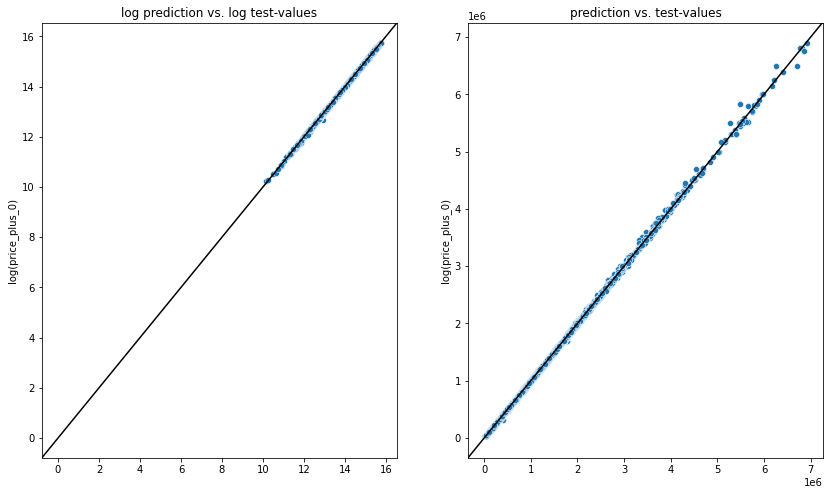

In [20]:
# Plotting log-continuous baseline + log_numerical_interactions predictions vs. test data
fig, ax = plt.subplots(1, 2, figsize = (14, 8))

sns.scatterplot(x = y_pred_2, y = y_test_log, ax = ax[0]);
sns.scatterplot(x = np.exp(y_pred_2), y = np.exp(y_test_log), ax = ax[1]);
ax[0].set_title('log prediction vs. log test-values');
ax[1].set_title('prediction vs. test-values');
ax[0].axline([0, 0], [1, 1], c = 'k');
ax[1].axline([0, 0], [1, 1], c = 'k');

In [21]:
# Bring in data that was cut for being upper outliers to test if model is actually working
# This data has never been part of train data and so should there should be no concern of data leakage
# Unless something went horribly wrong before train-test split
removed_test = pd.read_parquet('../data/cleaned/removed_test_data.parquet')

In [22]:
# Formatting data to conform to sklearn LinearRegression() requirements
# Splitting into X- and y-data
equalize_columns(X_train, removed_test)
y_removed_test_norm = removed_test.price
y_removed_test_log = removed_test['log(price_plus_0)']
X_removed_test = removed_test.drop(['price', 'log(price_plus_0)'], axis = 1)

In [23]:
# Running regression and showing R^2 scores
# Prediction scores still look pretty good, Test R^2 on log y: 0.9998
y_pred, df = run_linear_regression(X_train, y_train_log, X_removed_test, y_removed_test_log, X_col)
df.iloc[:2]

,param,coeff,p_values
0,Test R^2,0.999804,NaN
0,Train R^2,0.999932,NaN


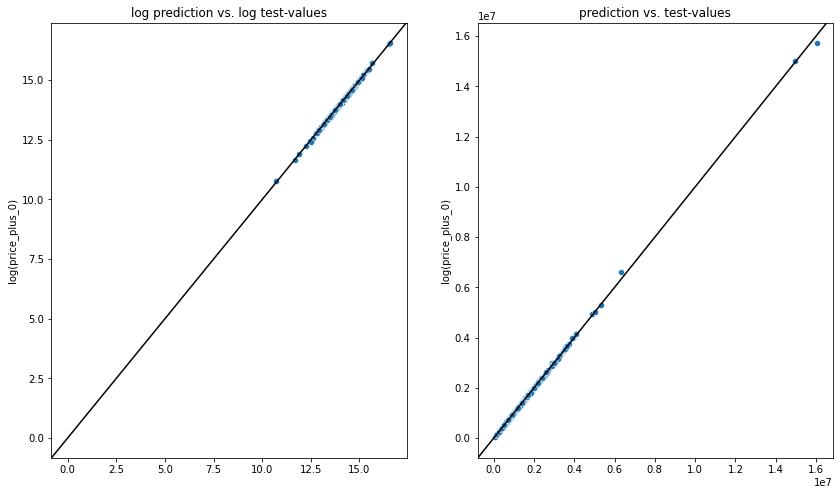

In [24]:
# Plotting log-continuous baseline + log_numerical_interactions predictions vs. removed data
# Model does appear to be performing well
fig, ax = plt.subplots(1, 2, figsize = (14, 8))

sns.scatterplot(x = y_pred, y = y_removed_test_log, ax = ax[0]);
sns.scatterplot(x = np.exp(y_pred), y = np.exp(y_removed_test_log), ax = ax[1]);
ax[0].set_title('log prediction vs. log test-values');
ax[1].set_title('prediction vs. test-values');
ax[0].axline([0, 0], [1, 1], c = 'k');
ax[1].axline([0, 0], [1, 1], c = 'k');